<a href="https://colab.research.google.com/github/clairecoffey/project/blob/master/claire_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness and the Bias/Variance Tradeoff 

## Claire Coffey

## May 2020

In this notebook we are studying bias and variance errors in the context of fairness, by exploring recidivism data. 

## Imports and Setup

Imports: first import the relevant libraries used throughout. 

In [0]:
# imports
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd

# Read in recidivism data 

In this notebook we are studying recidivism data. We utilise the COMPAS recidivism dataset, which uses recidivism data from Broward County jail and has been explored in the following studies:

"The accuracy, fairness, and limits of predicting recidivism", paper available at:
https://advances.sciencemag.org/content/4/1/eaao5580#corresp-1

"Machine Bias" ProPublica article, available at:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

The dataset used can be found at:
https://github.com/propublica/compas-analysis


Here we import and read in the recidivism data. Currently, we are using a selection of 500 samples from this dataset for our predictions.

We use a selection 
of fields from this dataset to predict recidivism classification (0 = will not reoffend; 1 = will reoffend).

In [0]:

def load_file():
  full_data = False
  print("loading data")
  if full_data:
    # full dataset
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/compas-scores-two-years%20-%20compas-scores-two-years.csv?token=ABPC6VNTFTGQBANNUJY2O4C6XGJGY"
  else:
    # small subset of first 500/1000 people
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/500-compas-scores-two-years%20-%20Sheet1%20(1).csv?token=ABPC6VOW7CBEIIGZVE6ZJYS6YKNHO"
    # file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/1000-compas-scores-two-years%20-%20Sheet1.csv"

  # load CSV contents
  all_data = pd.read_csv(file_path, delimiter=',', dtype={'sex': 'category', 
                                                          'age_cat': 'category',
                                                          'race': 'category',
                                                          'c_charge_degree': 'category',
                                                          'c_charge_desc': 'category',
                                                          'r_charge_degree': 'category',
                                                          'r_charge_desc': 'category',
                                                          'vr_charge_degree': 'category',
                                                          'vr_charge_desc': 'category'
                                                          })
  return all_data


In [493]:
all_data = load_file()
all_data

loading data


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,Male,1947-04-18,69,Greater than 45,Other,0,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,Male,1982-01-22,34,25 - 45,African-American,0,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,Male,1991-05-14,24,Less than 25,African-American,0,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,Male,1993-01-21,23,Less than 25,African-American,0,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,Male,1973-01-22,43,25 - 45,Other,0,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,495,kia rodriquez,kia,rodriquez,Female,1979-07-02,36,25 - 45,African-American,0,0,0,0,-1.0,2013-05-05 08:31:15,2013-05-17 08:35:57,13006433CF10A,2013-05-05,NaN,F,Aggrav Battery w/Deadly Weapon,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2013-05-05,2013-05-17,11,1061,0,0
333,496,jodie sena,jodie,sena,Female,1991-01-26,25,25 - 45,Caucasian,0,0,0,2,-2.0,2013-01-09 08:33:15,2013-01-10 09:40:18,13000518MM10A,2013-01-09,NaN,M,Petit Theft,1,13007257CF10A,(F3),0.0,2013-05-21,Possession of Cocaine,2013-05-21,2013-07-13,NaN,0,NaN,NaN,NaN,NaN,2013-03-06,2013-03-15,0,54,0,1
334,497,helen carrillo,helen,carrillo,Female,1992-06-09,23,Less than 25,Hispanic,0,0,0,1,0.0,2013-04-04 01:13:56,2013-04-04 11:28:44,13006418MM10A,2013-04-03,NaN,M,Operating W/O Valid License,1,15022411TC10A,(M2),0.0,2015-07-07,Operating W/O Valid License,2015-07-07,2015-07-17,NaN,0,NaN,NaN,NaN,NaN,2015-07-07,2015-07-17,0,824,1,0
335,499,justin knoll,justin,knoll,Male,1988-02-24,28,25 - 45,Caucasian,0,0,0,1,-4.0,2014-02-27 04:28:02,2014-02-28 08:49:55,14002778CF10A,2014-02-27,NaN,F,Pos Cannabis W/Intent Sel/Del,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,2014-07-16,2014-07-17,0,135,0,0


## Import and process data


We import the data into a pandas DataFrame. We begin by cleaning the data, so the crime descriptions are simplified, removing duplicate catefories. Then,  the categorical data is  split into different fields for each category, and encoded as 0 or 1. For example, an individual with characteristic "sex: male" would be encoded as "male: 1, female: 0". The sex category is then removed. 

We then consider which fields to use for prediction. This includes the removal of any fields/columns which contain many NaN values, since these cannot be handled by the classifiers. We choose to remove the columns with many NaNs rather than using an alternative approach such as replacing them with the average so as not to introduce other types of bias. We also then remove rows/individuals containing any further NaN values so there is no longer any NaN values present in the data. 

Finally, we define the number of testing/training samples desired and split the data into these two sets appropriately.


In [0]:
from sklearn import preprocessing

def clean_descriptions(description):
  description = description.replace(' and ', ' ')
  description = description.replace(' / ', ' ')
  description = description.replace('possession', 'posess')
  description = description.replace('possessing', 'posess')
  description = description.replace('with', 'w/')
  description = description.replace('w/ ', 'w/')
  description = description.replace('attempted', 'att')
  description = description.replace('attempt', 'att')
  description = description.replace('aggravated', 'agg')
  description = description.replace('aggrav', 'agg')

  return description

def import_data(all_data):

  split_by_sex = False
  num_testing_samples = 101

  encoded_sex = (pd.get_dummies(all_data['sex']))
  all_data = all_data.drop(columns=['sex'])
  all_data = all_data.join(encoded_sex)

  encoded_age_cat = (pd.get_dummies(all_data['age_cat']))
  all_data = all_data.drop(columns=['age_cat'])
  all_data = all_data.join(encoded_age_cat)

  encoded_race = (pd.get_dummies(all_data['race']))
  all_data = all_data.drop(columns=['race'])
  all_data = all_data.join(encoded_race)

  encoded_c_charge_degree = (pd.get_dummies(all_data['c_charge_degree']))
  all_data = all_data.drop(columns=['c_charge_degree'])
  all_data = all_data.join(encoded_c_charge_degree, rsuffix='_c')

  #these are joined with suffixes because otherwise columns overlap 
  all_data['c_charge_desc'] = all_data['c_charge_desc'].astype(str).str.lower()
  all_data['c_charge_desc'] = all_data['c_charge_desc'].apply(clean_descriptions)
  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_desc']))
  all_data = all_data.drop(columns=['c_charge_desc'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  encoded_r_charge_degree = (pd.get_dummies(all_data['r_charge_degree']))
  all_data = all_data.drop(columns=['r_charge_degree'])
  all_data = all_data.join(encoded_r_charge_degree, rsuffix='_r')

  all_data['r_charge_desc'] = all_data['r_charge_desc'].astype(str).str.lower()
  all_data['r_charge_desc'] = all_data['r_charge_desc'].apply(clean_descriptions)
  encoded_r_charge_desc = (pd.get_dummies(all_data['r_charge_desc']))
  all_data = all_data.drop(columns=['r_charge_desc'])
  all_data = all_data.join(encoded_r_charge_desc, rsuffix='_r')

  encoded_vr_charge_degree = (pd.get_dummies(all_data['vr_charge_degree']))
  all_data = all_data.drop(columns=['vr_charge_degree'])
  all_data = all_data.join(encoded_vr_charge_degree, rsuffix='_vr')

  all_data['vr_charge_desc'] = all_data['vr_charge_desc'].astype(str).str.lower()
  all_data['vr_charge_desc'] = all_data['vr_charge_desc'].apply(clean_descriptions)
  encoded_vr_charge_desc = (pd.get_dummies(all_data['vr_charge_desc']))
  all_data = all_data.drop(columns=['vr_charge_desc'])
  all_data = all_data.join(encoded_vr_charge_desc, rsuffix='_vr')

  all_data = all_data.drop(columns=['nan'])
  all_data = all_data.drop(columns=['nan_vr'])
  all_data = all_data.drop(columns=['nan_r'])

  #drop columns not used for predictions, including info such as names, and coluns with many NaN values 
  all_data_simplified = all_data.drop(columns=['two_year_recid', 'r_days_from_arrest', 'id','name','first','last','dob','days_b_screening_arrest','c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date','r_case_number','r_offense_date','r_jail_in','r_jail_out','vr_case_number','vr_offense_date','in_custody','out_custody','start','end','violent_recid'])

  #drop demographic info such as age, gender, race; keep only criminal records for predictions
  # all_data_simplified = all_data.drop(columns=['two_year_recid', 'r_days_from_arrest', 'id','name','first','last','dob','days_b_screening_arrest','c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date','r_case_number','r_offense_date','r_jail_in','r_jail_out','vr_case_number','vr_offense_date','in_custody','out_custody','start','end','violent_recid', 'age','Female','Male',	'25 - 45',	'Greater than 45',	'Less than 25',	'African-American',	'Caucasian',	'Hispanic',	'Other',	'F',	'M'])

  #remove rows containing NaN values 
  all_data_simplified = all_data_simplified.dropna()

  #Renormalise the data so we have unit variance and mean 0 using built-in preprocessing method in sklearn
  scaler = preprocessing.StandardScaler()
  all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data_simplified),columns=all_data_simplified.columns)

  all_data_and_labels = all_data_scaled.join(all_data[['two_year_recid']])

  #split into training and testing with specific number of testing samples
  #for now just set testing set to be first num_testing_samples samples in table 
  testing_data_and_labels = all_data_and_labels[:num_testing_samples]
  #and training set to be the remainder
  #this is also then consistent which is good for seeing patterns etc 
  training_data_and_labels = all_data_and_labels[num_testing_samples:]

  if(split_by_sex):
    testing_data_and_labels = pd.DataFrame.reset_index(testing_data_and_labels[testing_data_and_labels['Female']>0], drop=True)

  # print("normalised")
  # print(training_data_and_labels)

  # print(testing_data_and_labels)
  return training_data_and_labels, testing_data_and_labels

 

In [495]:
training_data_and_labels, testing_data_and_labels = import_data(all_data)
training_data_and_labels

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,is_violent_recid,event,Female,Male,25 - 45,Greater than 45,Less than 25,African-American,Caucasian,Hispanic,Other,F,M,agg assault w/dead weap,agg assault w/firearm,agg battery (firearm/actual posess),agg battery grt/bod/harm,agg battery pregnant,agg battery w/deadly weapon,agg fleeing eluding,agg fleeing/eluding high speed,agg stalking after injunctn,arrest case no charge,assault,att armed burglary dwell,att burg/struct/unocc,att robbery no weapon,att tamper w/physical evidence,battery,battery on law enforc officer,battery on parking enfor speci,burglary conveyance assault/bat,burglary conveyance unoccup,burglary dwelling assault/batt,...,prowling/loitering_r,resist/obstruct w/o violence_r,robbery no weapon_r,robbery w/firearm,susp drivers lic 1st offense_r,tamper w/witness/victim/ci,theft/to deprive,trespass after warning,trespass other struct/conve,trespass struct/conveyance_r,unlaw lictag/sticker attach_r,unlaw use false name/identity_r,uttering a forged instrument_r,viol injunct domestic violence_r,viol injunction protect dom violence,viol pretrial release dom viol,wear mask w/commit offense,(F1),(F2)_vr,(F3)_vr,(M1)_vr,(M2)_vr,(MO3)_vr,agg assault w/dead weap_vr,agg battery grt/bod/harm_vr,agg battery pregnant_vr,agg battery w/deadly weapon_vr,assault_vr,battery_vr,battery on a person over 65,battery on law enforc officer_vr,child abuse_vr,doc/fighting/threatening words_vr,felony battery,felony battery (dom strang)_vr,felony battery w/prior convict_vr,kidnapping (facilitate felony),manslaughter w/weapon,robbery w/firearm_vr,two_year_recid
101,-0.442613,-0.165647,-0.140020,-0.232829,-0.510630,-1.008942,-0.372174,-0.853349,-0.521247,0.521247,0.832747,-0.521247,-0.493500,1.058063,-0.758133,-0.295122,-0.301023,0.700821,-0.700821,-0.12272,-0.094774,-0.054554,-0.054554,-0.094774,-0.109599,-0.077267,-0.054554,-0.054554,-0.436821,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.417392,-0.12272,-0.054554,-0.054554,-0.077267,-0.054554,...,-0.077267,-0.192154,-0.054554,-0.054554,-0.12272,-0.077267,-0.054554,-0.054554,-0.054554,-0.054554,-0.077267,-0.094774,-0.077267,-0.109599,-0.054554,-0.054554,-0.054554,-0.094774,-0.134636,-0.192154,-0.237542,-0.054554,-0.054554,-0.109599,-0.077267,-0.054554,-0.077267,-0.054554,-0.230489,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.109599,-0.054554,-0.054554,-0.054554,-0.077267,0
102,0.299069,-0.165647,-0.140020,-0.232829,-0.707296,0.991137,2.686915,1.171853,1.918477,-1.918477,0.832747,-0.521247,-0.493500,-0.945123,1.319029,-0.295122,-0.301023,0.700821,-0.700821,8.14862,-0.094774,-0.054554,-0.054554,-0.094774,-0.109599,-0.077267,-0.054554,-0.054554,-0.436821,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.417392,-0.12272,-0.054554,-0.054554,-0.077267,-0.054554,...,-0.077267,-0.192154,-0.054554,-0.054554,-0.12272,-0.077267,-0.054554,-0.054554,-0.054554,-0.054554,-0.077267,-0.094774,-0.077267,-0.109599,-0.054554,-0.054554,-0.054554,-0.094774,-0.134636,-0.192154,4.209777,-0.054554,-0.054554,-0.109599,-0.077267,-0.054554,-0.077267,-0.054554,4.338609,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.109599,-0.054554,-0.054554,-0.054554,-0.077267,1
103,-0.937067,-0.165647,1.170719,4.008430,0.866029,0.991137,-0.372174,1.171853,-0.521247,0.521247,-1.200845,-0.521247,2.026342,-0.945123,1.319029,-0.295122,-0.301023,0.700821,-0.700821,-0.12272,-0.094774,-0.054554,-0.054554,-0.094774,-0.109599,-0.077267,-0.054554,-0.054554,-0.436821,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.417392,-0.12272,-0.054554,-0.054554,-0.077267,-0.054554,...,-0.077267,-0.192154,-0.054554,-0.054554,-0.12272,-0.077267,-0.054554,-0.054554,-0.054554,-0.054554,-0.077267,-0.094774,-0.077267,-0.109599,-0.054554,-0.054554,-0.054554,-0.094774,-0.134636,-0.192154,-0.237542,-0.054554,-0.054554,-0.109599,-0.077267,-0.054554,-0.077267,-0.054554,-0.230489,-0.054554,-0.054554,-0.054554,-0.054554,-0.054554,-0.109599,-0.054554,-0.054554,-0.054554,-0.

# Classification

##Selecting Classifiers

Here we select the classification model to use. We are using a selection of built-in classifiers in scikit-learn. 

Currently, we are using RBF SVM models (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

We define the boolean values ```vary_gamma ``` and  ```vary_c``` to define whether we are varying the gamma or C value in the classifiers. 




In [0]:
from sklearn import model_selection, neighbors, svm, gaussian_process, tree, ensemble, neural_network, metrics

def define_classifiers():

  vary_gamma = True
  vary_c = False 
  gammas = []
  cs = []
  classifiers = []

  if vary_gamma:
    # gammas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 10000]
    gammas = [0.01]
    # gammas = [0.0001]
    c_val = 1
    #fix size of C if varying gamma
    for gamma_val in gammas:
      classifiers.append(svm.SVC(gamma=gamma_val,C=c_val))

  if vary_c:
    cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    gamma_val = 0.01
    #fix size of gamma if varying C
    for c_val in cs:
      classifiers.append(svm.SVC(gamma=gamma_val,C=c_val))

  return classifiers, gammas, cs


In [0]:
# define_classifiers()

## Bootstrapping 

The classification process then uses a bootstrapping procedure with the chosen model, to generate predictions of recidivism classifications (1 = will reoffend; 0 = will not reoffend).

Bootstrapping (https://link.springer.com/chapter/10.1007/978-1-4612-4380-9_41) is a sampling with replacement procedure. Here, the sample size is the same as the size of the (training) dataset. The bootstrapping procedure is run many times to generate different training datasets, which will then be used for classification. In turn, the classification results will be used to calculate and study the bias and variance errors. 

In [0]:
def do_bootstrap(training_data_and_labels):
  # this is one bootstrap sample 
  indices = np.random.randint(0,training_data_and_labels.shape[0] , training_data_and_labels.shape[0])
  indices.sort()
  data_points = []

  for i in indices:
    data_points.append(training_data_and_labels.iloc[i])

  b_sample = pd.DataFrame(data_points)

  return b_sample

In [0]:
# b_sample = do_bootstrap(training_data_and_labels)

## Perform classification


Fit the model on the training data (which is one bootstrap data sample as defined above)


In [0]:
def fit_model(clf, b_sample, testing_data_and_labels):

    #training data is everything apart from two year recid 0/1 label from the bootstrap sample
    X_train = b_sample.drop(columns=['two_year_recid'])
    y_train = b_sample['two_year_recid']
    X_test = testing_data_and_labels.drop(columns=['two_year_recid'])
    y_test = testing_data_and_labels['two_year_recid']

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test

    return y_pred, y_true

Perform classification for each bootstrap sample separately, and store these in a DataFrame, to be passed into the bias/variance calculations.

In [0]:
def classify(training_data_and_labels, testing_data_and_labels, clf):
    count = 0

    num_bootstraps = len(training_data_and_labels);
    while count <= num_bootstraps:
      b_sample = do_bootstrap(training_data_and_labels)
      y_pred, y_true = fit_model(clf, b_sample, testing_data_and_labels)
      if(count == 0):
        predictions = pd.DataFrame(pd.Series(y_pred)).transpose()
        #true labels are the same for every sample so we only need 1 row in df
        true_labels = pd.DataFrame(pd.Series(y_true)).transpose()
      else:
        predictions = predictions.append(pd.DataFrame(pd.Series(y_pred)).transpose())
      count += 1
      
    return predictions, true_labels

In [0]:
# classify(training_data_and_labels, testing_data_and_labels, clf)


# Compute bias/variance errors

Using all these bootstrap predictions, we calculate the average misclassification error. This is done by first calculating the overall misclassification loss across bootstrap sample predictions, finding the average misclassification error for each datapoint (individual). As described in:
http://www.cems.uwe.ac.uk/~irjohnso/coursenotes/uqc832/tr-bias.pdf

We can then decompose the error into the errors due to bias, and the errors due to variance, in order to study the behaviour of the model and the bias/variance tradeoff. This decomposition for classification is described in: 
https://homes.cs.washington.edu/~pedrod/bvd.pdf
https://pdfs.semanticscholar.org/9253/f3e13bca7e845e60394d85ddaec0d4cfc6d6.pdf https://www.stat.berkeley.edu/users/breiman/arcall96.pdf. 

The error is also comprised of an error due to noise (in addition to bias and variance). However, as stated in http://papers.nips.cc/paper/7613-why-is-my-classifier-discriminatory.pdf, the noise is dependent on the data, not the model, so comparing the discrimination level in the form of bias and variance errors, the noise terms cancel since they are independent of the model. Therefore, differences in bias can be explored even without knowing the underlying noise of the data. 

We calculate the bias and variance errors for each individual, following zero-one loss rules under misclassification loss, as described in https://homes.cs.washington.edu/~pedrod/bvd.pdf. We can then calculate the overall average bias error and variance error for the prediction. 


In [0]:
def compute_bias_variance(predictions, true_labels):

  # print("predictions: ")
  # print(predictions)
  # print("true labels: ")
  # print(true_labels)

  biases = []
  variances = []
  avg_errors = []
  misclassified_individuals = []

  # calculate the bias and variance for each value of X,y
  # for misclassification loss
  
  #find whether each element is misclassified for each bootstrap sample 
  predictions_misclassified = predictions.apply(lambda x : x != true_labels.iloc[0], axis=1)

  #count number of times misclassified for each datapoint across all bootstrap samples 
  counts = predictions_misclassified.apply(np.sum)

  #average misclassification error for each individual/datapoint 
  avg_errors = counts.apply(lambda y : np.divide(y,len(predictions)))

  index = 0

  for avg_error in avg_errors:
    (bias, variance) = (0, avg_error) if (avg_error <= 0.5) else (1, (1-avg_error))
    # print(bias)
    # print(variance)
    biases.append(bias)
    variances.append(variance)
    if avg_error > 0.5:
      misclassified_individuals.append(index)
    index+= 1

  avg_bias = np.mean(biases)
  # avg_var = abs(np.mean(avg_errors) - avg_bias)
  avg_var = abs(np.mean(variances))
  avg_error = np.mean(avg_errors)

  print("average error:")
  print(avg_error)
  print("average bias:")
  print(avg_bias)
  print("average variance:")
  print(avg_var)

  return avg_bias, avg_var, avg_error, misclassified_individuals

# Fairness

We will now explore the relationship between the bias and variance error types, as discussed above, and fairness. The definition of 'fairness' is disputed. For the purposes of our exploration, we will begin by defining fairness as simply the difference between the values of different error types for specific sub-groups of individuals in the dataset, as in http://papers.nips.cc/paper/7613-why-is-my-classifier-discriminatory.pdf. In this paper, they explore potential discrimination, and therefore fairness, by focus on specific protected characteristics (i.e. race, age) and the error rates for these sub-groups. We can explore the errors in relation to these, but we are also interested in addressing new categories of discrimination by identifying the relationship between bias and variance errors and the introduction of new categories of discrimination. 

We define a 'fair' model to be one that predicts equally well for individuals with all characteristics, i.e. the bias/variance errors are equally distributed across individuals in different groups/ with different characteristics. This is usually explored in the context of protected characteristics since these are able to clearly be identified and 'tested'. We are interested in finding categories of individuals that are not necessarily based on protected characteristics (although these are clearly a major source of discrimination). But it can be damaging if a specific category of individual is being consistently discriminated against, even if it is not based on protected characteristics - i.e. when variance is low and bias high (http://inverseprobability.com/2017/11/15/decision-making). 


In [0]:
 #look at individuals that are being misclassified i.e. when error is due to bias
 #then try and cluster these in some way / find what they have in common

#i think we should look for patterns when bias is high - which individuals is it misclassifying?
#in order to identify new categories i need to do clustering in some way, like plot the individuals vs their errors but this doesn't make sense, 

#can i plot the individuals which are always being predicted wrong? that's what i want to loook at i think, if there is high bias and low variance then there will be consistently wrong predictions 


## Identifying Categories of Discrimination 

We hope to address the question: Are models that exhibit high bias errors likely to introduce new categories of discrimination? 

We can therefore look at the bias and variance errors for different models.


We want to see that if the variance is low and bias high, is it consistently discriminating against a certain subgroup? doesn't have to be protected characteristic.

# Plots

Creating the appropriate plots to visualise our results. We plot: 

1.   Bias error vs Variance error
2.   Gamma value of RBF SVM vs Variance error
3.   Gamma value of RBF SVM vs Bias error


In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance(biases, variances, gammas, cs, errors):   
  print("plotting bias/var") 
  plt.scatter(biases, variances)                                              
  plt.title('bias vs variance errors')                                     
  plt.xlabel('bias')                                                       
  plt.ylabel('variance')                                                   
  plt.show()

  plt.scatter(gammas, variances)
  plt.xscale('log')                                              
  plt.title('RBF SVM, C = 1 \n gamma size vs variance errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('variance')                                                   
  plt.show()                                                            

  plt.scatter(gammas, biases)                               
  plt.xscale('log')                                                             
  plt.title('RBF SVM, C = 1 \n gamma size vs bias errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('bias')                                                   
  plt.show()            

  plt.scatter(gammas, errors)                               
  plt.xscale('log')                                                             
  plt.title('RBF SVM, C = 1 \n gamma size vs total error')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('error')                                                   
  plt.show()   

  # plt.scatter(cs, biases)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, gamma=0.01, C value vs bias errors')                                     
  # plt.xlabel('C value')                                                       
  # plt.ylabel('bias')                                                   
  # plt.show()       

  # plt.scatter(cs, variances)                               
  # plt.xscale('log')                                                             
  # plt.title('RBF SVM, gamma=0.01, C value vs variance errors')                                     
  # plt.xlabel('C value')                                                       
  # plt.ylabel('variance')                                                   
  # plt.show()       


def plot_misclassified(misclassified):
  misclassified.reset_index().plot(kind='scatter', x='index', y='age') 
  plt.show()
  misclassified.reset_index().plot(kind='scatter', x='index', y='Female') 
  plt.show()

# Main method (execute code)

Main method to run the system, executing methods in appropriate sequence. 

In [0]:
def main():
  all_data = load_file()
  training_data_and_labels, testing_data_and_labels = import_data(all_data)
  biases = []
  variances = []
  total_errors = []
  classifiers, gammas, cs = define_classifiers()
  misclassified = []

  for classifier in classifiers:
    print(classifier)
    # clf = classifiers[classifier_names.index(classifier)]
    clf = classifier
    predictions, true_labels = classify(training_data_and_labels, testing_data_and_labels, clf)  
    bias, variance, total_error, misclassified_individuals = compute_bias_variance(predictions, true_labels)
    biases.append(bias)
    variances.append(variance)
    total_errors.append(total_error)
    #get the individuals which are misclassified on average (hence contributing to bias errors)
    print(misclassified_individuals)
    #by cross referencing misclassified indexes with testing data 
    misclassified = testing_data_and_labels.iloc[misclassified_individuals]
    plot_misclassified(misclassified)
    
  #i can look at the difference between the errors for different subgroups, but what i don't get is how to identify new categories being discriminated against
  #so i guess lets start by plotting the difference between errors for test data of females vs males e.g.?
  #i also need to think about the training data being biased in general e.g. skewed by gender, age, etc - this affects predicitons as well

  plot_bias_variance(biases, variances, gammas, cs, total_errors)

  return misclassified


loading data
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
average error:
0.1158039854618373
average bias:
0.10891089108910891
average variance:
0.029786522956093072
[10, 23, 25, 29, 34, 41, 49, 54, 66, 71, 96]


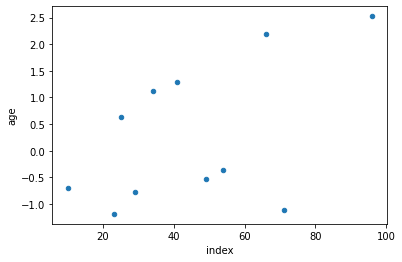

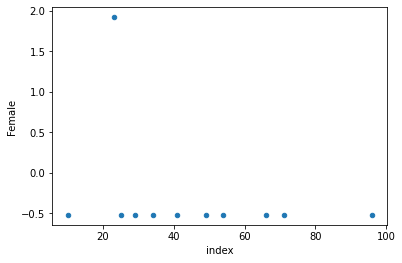

plotting bias/var


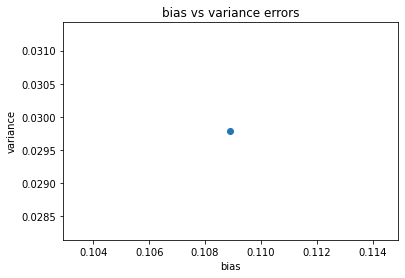

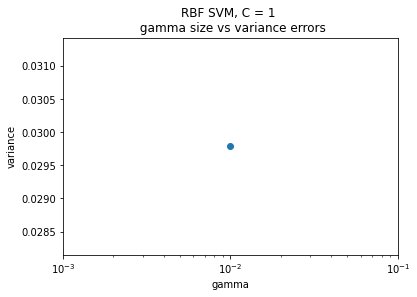

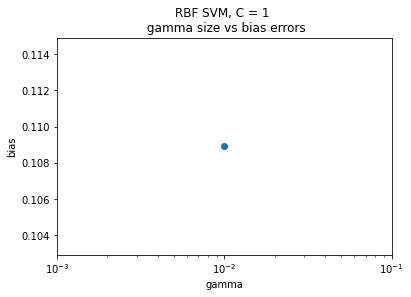

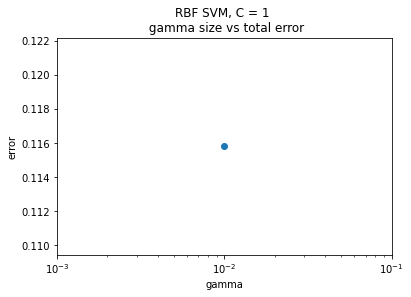

In [507]:
misclassified = main()

misclassified.reset_index().to_csv('misclassified.csv', index=False)
from google.colab import files
files.download('misclassified.csv')

